In [52]:
import os
import numpy as np
import pandas as pd
import rasterio as rio
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')
from scipy.stats import skew, kurtosis

# Task 1: How can we leverage mutliple data sources to produce a single flood map?

This task is designed to assess the your ability to query, pre-process, inspect, and validate a diverse range of data sources, especially remotely sensed data, to inform and validate flood models.

Given $N$ candidate input raster layers, $\textbf{X} = \{{X_1, X_2, ..., X_N}\}$, we at Cloud to Street would like to learn the parameters of some model $f(X)$ that can predict the fractional flooded area of a grid cell (pixel) $Y$.

We would like you to **complete an exploratory data analysis of some candidate input rasters**, $\textbf{X}$, in the context of this floodmapping task. Your analysis at minimum should include:
1. A quantitative summary of each candidate layer
2. A visual summary of quantiles and outliers in each data layer.
3. Discussion of the merits/drawbacks of these layers. At minimum, you should comment on:
  * Which data layers appear to have the "richest" information about flooding and why?
  * Which data layers appear to have the "least" amount of information about flooding and why?
4. Potential preprocessing steps you would apply to any of the layers prior to training a model? If so, be specific about:
  * which layer(s)
  * what transformation(s) and provide examples with code and visualizations where possible
  * What classes of models would the transformation be appropriate for (ex. Random Forests, SVMs, Logistic Regression, Convolutional Networks)
5. Additional commentory with considerations for modelling or determining what models are appropriate.

Use whichever technology and/or programming language you are most comfortable with to complete the task. You can use a copy of this Google Colab, or create your own code, noteboook, etc. Your submission should contain all the necessary instructions and files to recreate your result (jupyter notebooks, source code, execution instructions, python/R/Matlab version).

We will grade this task purely on the results of the analysis, with the requirement that the submitted code should be able to run as instructed and readable. No assessment of code style or quality will be made.


## Task 1-1 A quantitative summary of each candidate layer
In order to provide a quantitative summary of each `.tif` file, first the root path for `.tif` files in each main directory (training example) were created and appended to a python list, `list_of_images_path`. After that, tif files were read, flattened and attached to a pandas dataframe as an individual column. So the resulting pandas dataframe represents one training example and include each candidate layer as a column of data. Finally, using `.describe()` method in pandas dataframe the descriptive statistics of each column (candidate layer) was calculated.

In [77]:
dir_list = os.listdir('data/')
print(dir_list)

['example_houston_model_output.png', 'MOD09GA.A2001352.h10v05.006.2015146051459__512-1024', 'MOD09GA.A2008169.h11v04.006.2015175230035__512-1024', 'MOD09GA.A2011126.h10v05.006.2015218092242__512-1024', 'model_output_houston_historical_water_area.csv', 'MYD09GA.A2005014.h11v05.006.2015098234609__0-512', 'MYD09GA.A2005256.h10v06.006.2015108002700__512-684', 'MYD09GA.A2006004.h08v05.006.2015113085023__0-512']


In [110]:
data_root='data/MOD09GA.A2001352.h10v05.006.2015146051459__512-1024'
list_of_columns = []
list_of_images_path = []
for root, dirs, files in os.walk(os.path.join(data_root, 'imagery'), topdown=True):
    # print(dirs)
    for file in files:
        if file.endswith('.tif'):
            list_of_columns.append(file.split('.')[0])
            list_of_images_path.append(os.path.join(root, file))
# print(list_of_images_path)
# print(list_of_columns)

In [111]:
df = pd.DataFrame(columns=list_of_columns)
# df

In [112]:
for index, path in enumerate(list_of_images_path):
    with rio.open(path) as src:
        x = src.read(1)
        # pprint(src.profile) # detailed raster metadata
        x = x.astype(np.float32)
        x[x==src.nodata] = 0

        df[list_of_columns[index]] = x.ravel()

In [113]:
df_describe = df.describe()
df_describe.to_csv(f'{data_root}/results/descriptive_stats.csv', sep=',', encoding='utf-8', index=False)
df_describe

,flow_acc,flow_dir,gridmet_pr,gridmet_pr_3days,gridmet_pr_5days,gridmet_pr_7days,GSW,hand,rt_72h_max,rt_72h_mean,sm_t0,sm_tm24_tm0,sm_tm48_tm24,sm_tm72_tm48,streamflow
count,2.841600e+05,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000
mean,1.489512e+04,26.965271,0.667427,435.740021,546.290344,1037.787109,2.983008,14.974836,7.469668,2.964767,39.599796,39.945976,39.313156,38.514633,79.440056
std,1.886761e+05,17.864946,6.370377,342.661896,423.278809,497.582367,14.134555,18.031885,13.792254,6.882548,10.007306,10.025323,10.108237,10.218264,730.667542
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,14.000000,14.000000,14.000000,0.000000
25%,3.024518e+00,12.488005,0.000000,179.000000,208.000000,708.000000,0.000000,3.851591,1.000000,0.040000,35.000000,35.000000,35.000000,34.000000,0.056843
50%,8.370121e+00,23.361378,0.000000,304.000000,382.000000,1015.000000,0.003684,9.661176,3.000000,0.760000,38.000000,38.000000,38.000000,37.000000,0.375494
75%,4.692364e+01,38.573740,0.000000,672.000000,849.000000,1430.000000,0.119781,19.644253,8.000000,2.440000,42.000000,42.000000,41.000000,40.000000,2.354234
max,4.811762e+06,118.175011,146.000000,2007.000000,2390.000000,2753.000000,100.000000,391.457092,422.000000,372.920013,100.000000,100.000000,100.000000,100.000000,18959.378906


## Task 1-2 A visual summary of quantiles and outliers in each data layer.
One simple and useful method for visually illustrating the quantiles and outliers of each data is boxplot. Here, both boxplot and histrogram were used to show not only the quantiles and outliers but also give a picture of data distribution for each candidate layer. kurtosis and skewness of each layer were shown on top of the corresponding histogram. "Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point. Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case" [itl.nist.gov](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm#:~:text=Skewness%20is%20a%20measure%20of,relative%20to%20a%20normal%20distribution.).


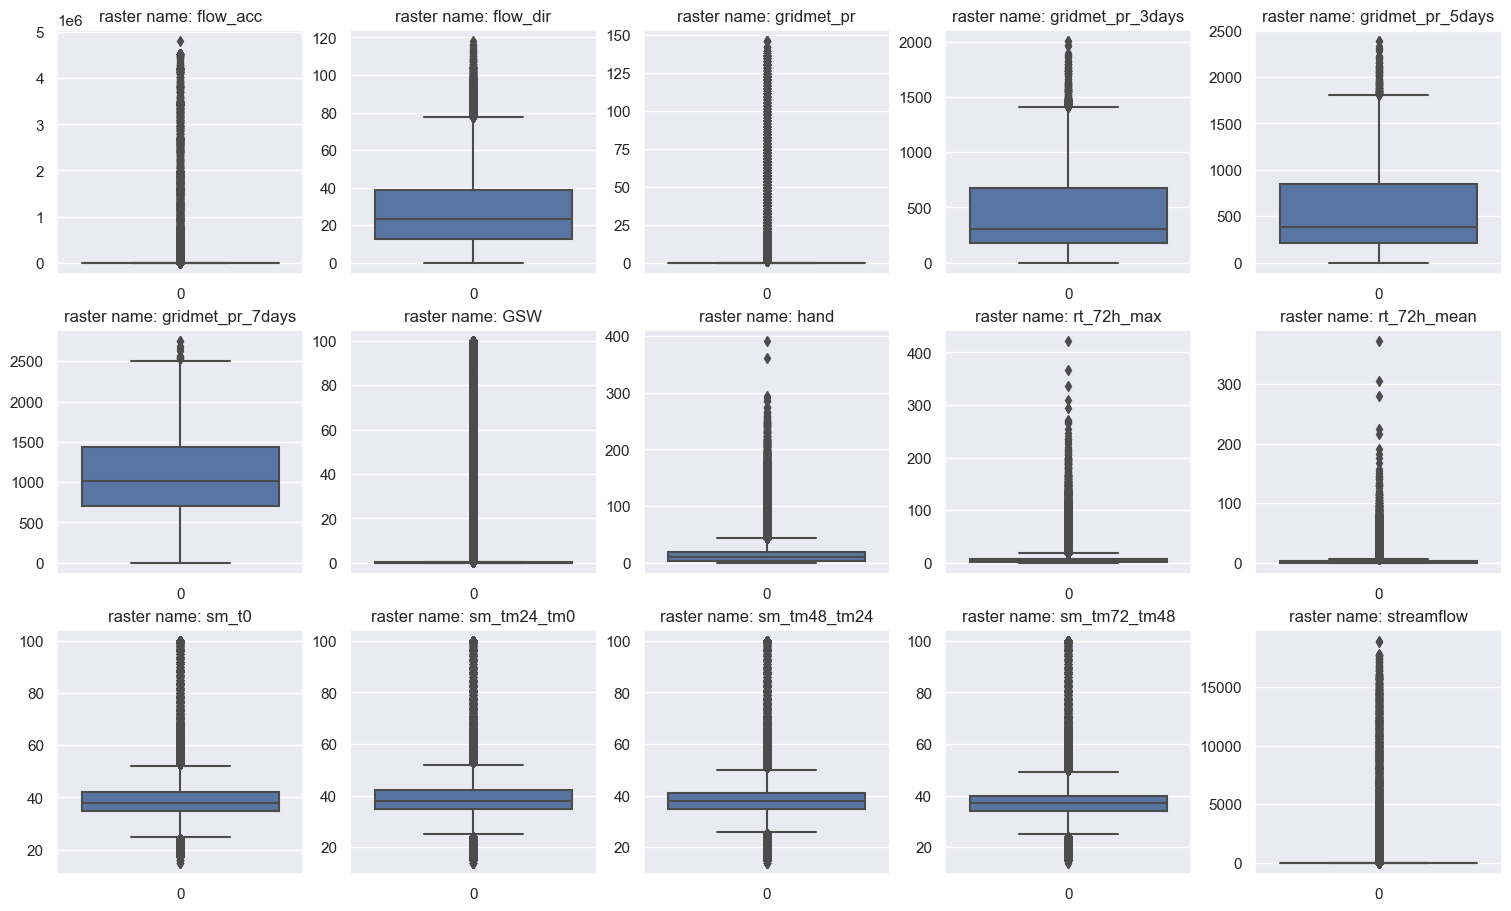

In [114]:
fig, axes = plt.subplots(nrows=3, ncols=5 , figsize=(15, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(df.iteritems()):

    i, j = divmod(index, 5)

    sns.boxplot(data=column_data, orient='v', ax=axes[i, j])
    axes[i, j].set_title(f'raster name: {column_name}')
    axes[i, j].set_xlabel('')

plt.savefig(f'{data_root}/results/boxplots.png')
plt.show()

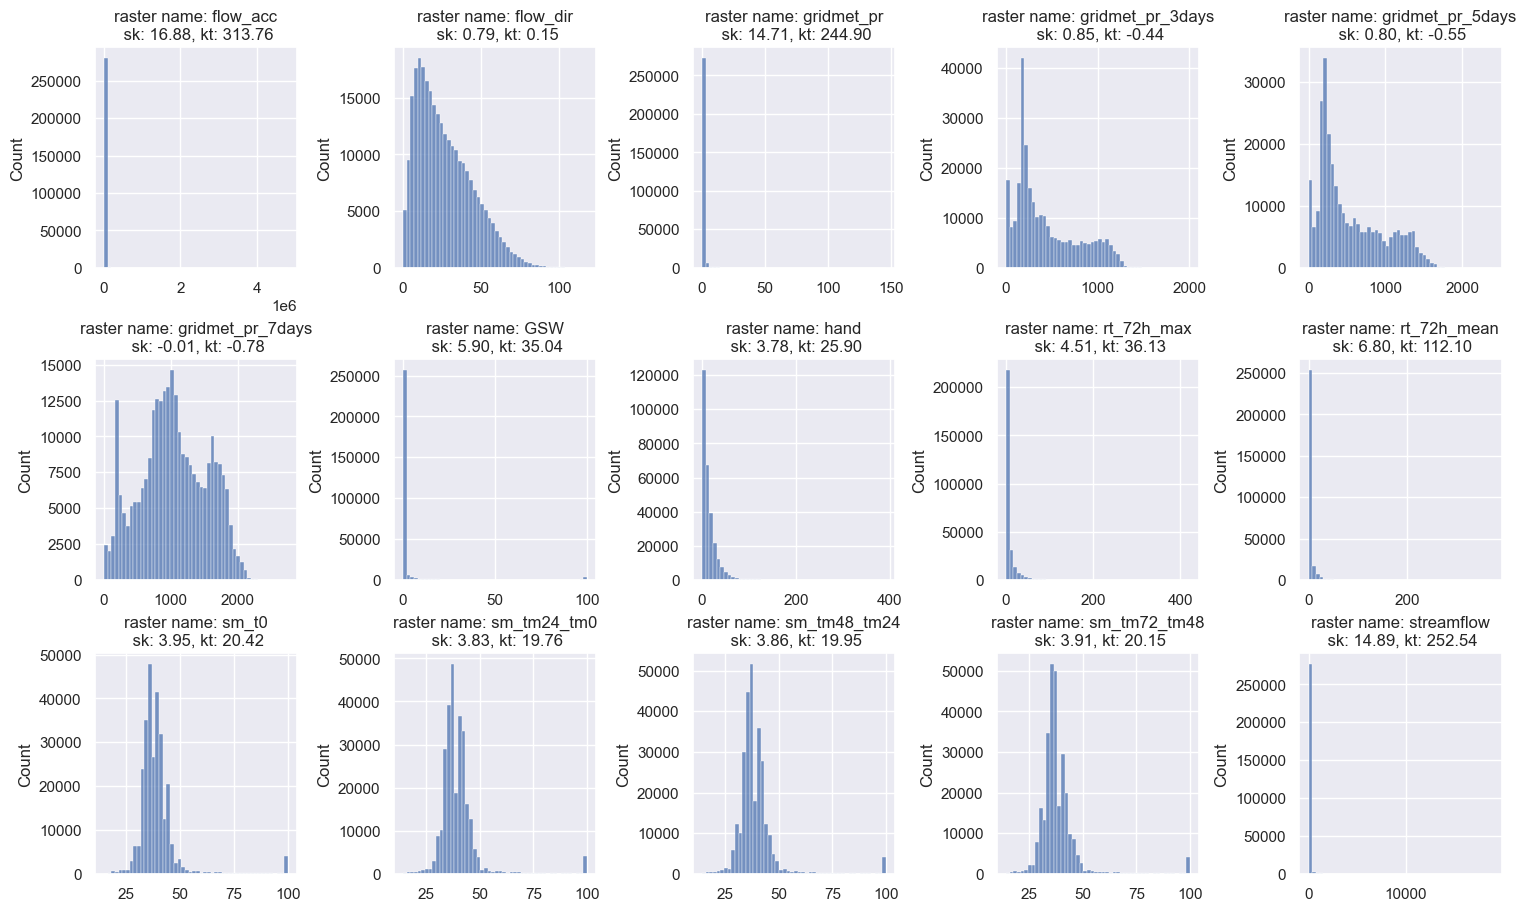

In [115]:
fig, axes = plt.subplots(nrows=3, ncols=5 , figsize=(15, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(df.iteritems()):
    i, j = divmod(index, 5)

    sns.histplot(x=column_data.values, bins=50, ax=axes[i, j])
    axes[i, j].set_title(f'raster name: {column_name}\n sk: {skew(column_data.values):.2f}, kt: {kurtosis(column_data.values):.2f}')
    axes[i, j].set_xlabel('')

plt.savefig(f'{data_root}/results/histrograms.png')
plt.show()

## Task 1-3 Discussion of the merits/drawbacks of these layers.

### Which data layers appear to have the "richest" information about flooding and why?

#### HAND
HAND stands for the Height Above Nearest Drainage, and it, alone!, can be considered as a conceptual method for flood inundation mapping. `HAND` can be estimated for each catchment by using a digital elevation model (DEM) of the terrain and a spatial representation of a river network (commonly come from National Hydrography Datasets-- NHD). So, by having water stage, HAND can estimate inundation zone and a water depth grid. Water stage can be derived from synthetic rating-curves (it would be good to provide different scenarios) or the outcome of **Channel and Lake Routing** module of NWM. In NWM, depending on what algorithm is being used-- gridded or linked routing-- physical model (1D Diffusive Wave approximation) or conceptual models (Muskingum or Muskingum-Cunge) can be adopted for performing channel routing. `HAND` raster include rich information for flood as it derived from DEM and river network.

##### References

- Zheng, Xing, et al. "River channel geometry and rating curve estimation using height above the nearest drainage." JAWRA Journal of the American Water Resources Association 54.4 (2018): 785-806.
- Johnson, J. Michael, et al. "An integrated evaluation of the national water model (NWM)–Height above nearest drainage (HAND) flood mapping methodology." Natural Hazards and Earth System Sciences 19.11 (2019): 2405-2420.
- Gochis, D.J., et al. "The WRF-Hydro® modeling system technical description." (2020): Version 5.1.1

#### NWM Routing Previous 72h Mean
For surface overland flow routing, NWM uses a physical model, i.e., 2D diffusive wave approximation formulated by Ogden 1997. And Channel routing is based on a mass balance calculation, where the channel routes water when the ponded water depth (of the grid cells) exceeds the retention depth which is a combination of the local infiltration excess, the amount of water flowing onto the grid cell from overland flow, and exfiltration from groundwater flow.

##### References
- Gochis, D.J., et al. "The WRF-Hydro® modeling system technical description." (2020): Version 5.1.1


#### NWM Soil Moisture tm72-tm48
Water will pond on the surface only if the rainfall intensity is greater than the infiltration capacity of the soil, the process of water penetrating from the ground surface into the soil, and soil moisture has direct effect on infiltration capacity. In NWM, the exfiltration from a supersaturated soil column is added to infiltration excess from the land surface model, which ultimately updates the value of surface head prior to routing of overland flow.

##### References
- Chow, Ven Te, David R. Maidment, and W. Larry. "Mays. Applied Hydrology." International edition, MacGraw-Hill, Inc 149 (1988).


#### Global Surface Water

`Flow Direction`, `Flow Accumulation`,

### Which data layers appear to have the "least" amount of information about flooding and why?